https://github.com/ronakvijay/Protein_Sequence_Classification/blob/master/Pfam_protein_sequence_classification.ipynb

https://towardsdatascience.com/protein-sequence-classification-99c80d0ad2df

In [1]:
from google.colab import drive
drive.mount("/content/drive/")
import os 
os.chdir("/content/drive/MyDrive/Challenge/")

Mounted at /content/drive/


In [2]:
import csv
import numpy as np
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

import math

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import numpy as np
import networkx as nx
import sklearn
from sklearn import preprocessing

In [3]:
sequences = list()
print('sequences.txt')
with open('sequences.txt', 'r') as f:
    for line in f:
        sequences.append(line[:-1])

# Split data into training and test sets
sequences_train = list()
sequences_test = list()
proteins_test = list()
y_train = list()
with open('graph_labels.txt', 'r') as f:
    for i,line in enumerate(f):
        t = line.split(',')
        if len(t[1][:-1]) == 0:
            proteins_test.append(t[0])
            sequences_test.append(sequences[i])
        else:
            sequences_train.append(sequences[i])
            y_train.append(int(t[1][:-1]))
sequences_train = np.array(sequences_train)
y_train = np.array(y_train)

sequences.txt


In [4]:
len(sequences)

6111

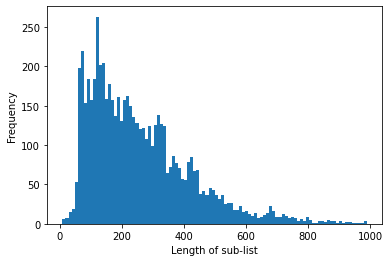

In [5]:
import matplotlib.pyplot as plt

lengths = [len(sublist) for sublist in sequences]

# Plot a histogram of the lengths
plt.hist(lengths, bins=100)

# Add labels to the x and y axes
plt.xlabel('Length of sub-list')
plt.ylabel('Frequency')

# Display the histogram
plt.show()

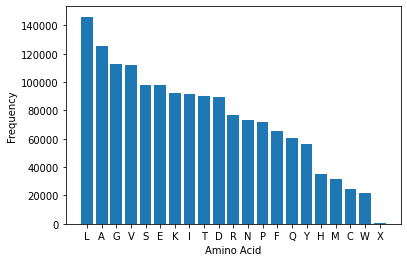

In [6]:
from collections import Counter


# Initialize a dictionary to store the frequency of each amino acid
amino_acid_counts = {}

# Iterate over the sequences
for seq in sequences:
    # Count the frequency of each amino acid in the current sequence
    counts = Counter(seq)
    # Iterate over the counts
    for amino_acid, count in counts.items():
        # If the amino acid is not already in the dictionary, add it
        if amino_acid not in amino_acid_counts:
            amino_acid_counts[amino_acid] = 0
        # Add the count to the count for the current amino acid
        amino_acid_counts[amino_acid] += count

sorted_amino_acid_counts = dict(sorted(amino_acid_counts.items(), key=lambda item: item[1], reverse=True))

# Plot a bar chart of the frequency of each amino acid
plt.bar(sorted_amino_acid_counts.keys(), sorted_amino_acid_counts.values())

# Add labels to the x and y axes
plt.xlabel('Amino Acid')
plt.ylabel('Frequency')

# Display the bar chart
plt.show()

In [7]:
def create_dict(codes):
  char_dict = {}
  c=0
  for seq in codes:
    for letter in seq:
      if letter not in char_dict.keys():
        char_dict[letter] = c+1
        c+=1

  return char_dict

char_dict = create_dict(sequences)

def integer_encoding(data):
  """
  - Encodes code sequence to integer values.
  - 20 common amino acids are taken into consideration
    and rest 4 are categorized as 0.
  """
  
  encode_list = []
  for row in data:
    row_encode = []
    for code in row:
      row_encode.append(char_dict.get(code, 0))
    encode_list.append(np.array(row_encode))
  
  return encode_list

from sklearn.model_selection import train_test_split

sequences_train_ , sequences_val, y_train_, y_val = train_test_split(sequences_train,y_train ,
                                   random_state=104, 
                                   test_size=0.1, 
                                   shuffle=True)
train_sm = sequences_train_
val_sm = sequences_val
test_sm = sequences_test
train_encode = integer_encoding(train_sm)
val_encode = integer_encoding(val_sm)
test_encode = integer_encoding(test_sm)
# train_encode = [integer_encoding(seq.tolist()) for seq in train_sm]
# val_encode = [integer_encoding(seq.tolist()) for seq in val_sm]
# test_encode = [integer_encoding([i for i in seq]) for seq in test_sm]

In [8]:
from keras_preprocessing.sequence import pad_sequences

# padding sequences
max_length = 512
train_pad = pad_sequences(train_encode, maxlen=max_length, padding='post', truncating='post')
val_pad = pad_sequences(val_encode, maxlen=max_length, padding='post', truncating='post')
test_pad = pad_sequences(test_encode, maxlen=max_length, padding='post', truncating='post')

train_pad.shape, val_pad.shape, test_pad.shape

((4399, 512), (489, 512), (1223, 512))

In [9]:
from keras.utils import to_categorical

# One hot encoding of sequences
train_ohe = to_categorical(train_pad)
val_ohe = to_categorical(val_pad)
test_ohe = to_categorical(test_pad)

train_ohe.shape, test_ohe.shape, test_ohe.shape 

((4399, 512, 22), (1223, 512, 22), (1223, 512, 22))

In [10]:
def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

#LSTM

In [11]:
import numpy as np
from tensorflow.keras.datasets import imdb

from tensorflow.keras import backend as K
from tensorflow.keras import Model,losses
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Dense, Activation, Embedding, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector, Bidirectional

In [12]:
top_words = 22
embedding_vector_length = 32

inputs = Input(shape=(max_length,))
embedding = Embedding(input_dim=top_words, output_dim=embedding_vector_length, input_length=max_length)(inputs)
# lstm = Bidirectional(LSTM(128)(embedding))
lstm = Bidirectional(LSTM(128, return_sequences=True))(embedding)
lstm1 = Bidirectional(LSTM(128))(lstm)
dense = Dense(22, activation="sigmoid")
x = dense(lstm1)
model = Model(inputs=inputs, outputs=x)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512)]             0         
                                                                 
 embedding (Embedding)       (None, 512, 32)           704       
                                                                 
 bidirectional (Bidirectiona  (None, 512, 256)         164864    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 22)                5654      
                                                                 
Total params: 565,462
Trainable params: 565,462
Non-trainable

In [13]:
# --- compile and fit the model
model.compile(loss= 'sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm = model.fit(train_pad, y_train_, epochs=130, batch_size=1024, validation_data=(val_pad, y_val))

Epoch 1/130
5/5 [==============================] - 14s 1s/step - loss: 3.0483 - accuracy: 0.1748 - val_loss: 2.8458 - val_accuracy: 0.2045
Epoch 2/130
5/5 [==============================] - 4s 737ms/step - loss: 2.6170 - accuracy: 0.2041 - val_loss: 2.4889 - val_accuracy: 0.1943
Epoch 3/130
5/5 [==============================] - 4s 740ms/step - loss: 2.4181 - accuracy: 0.1919 - val_loss: 2.4614 - val_accuracy: 0.1943
Epoch 4/130
5/5 [==============================] - 4s 741ms/step - loss: 2.3862 - accuracy: 0.2019 - val_loss: 2.3963 - val_accuracy: 0.2045
Epoch 5/130
5/5 [==============================] - 4s 744ms/step - loss: 2.3667 - accuracy: 0.2041 - val_loss: 2.3869 - val_accuracy: 0.1984
Epoch 6/130
5/5 [==============================] - 4s 746ms/step - loss: 2.3625 - accuracy: 0.2355 - val_loss: 2.3894 - val_accuracy: 0.1984
Epoch 7/130
5/5 [==============================] - 4s 745ms/step - loss: 2.3549 - accuracy: 0.2060 - val_loss: 2.3919 - val_accuracy: 0.2065
Epoch 8/130
5/5

In [ ]:
pip install --upgrade torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.8/776.8 MB 1.8 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116
    Uninstalling torch-1.13.1+cu116:
      Successfully uninstalled torch-1.13.1+cu116
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.14.1+cu116 requires torch==1.13.1, but you have torch 1.7.0 which is incompatible.
torchtext 0.14.1 requires torch==1.13.1, but you have torch 1.7.0 which is incompatible.
torchaudio 0.13.1+cu116 requires torch==1.13.1, but you have torch 1.7.0 which is incompatible.


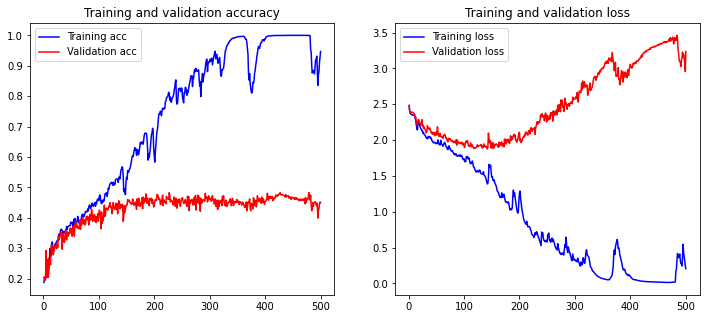

In [ ]:
plot_history(model_lstm)

In [ ]:
input_data = [torch.from_numpy(x) for x in test_pad]
input_data = torch.LongTensor(input_data)

# test_pad_t = torch.LongTensor(input_data)
inputs = input_data.to(device) # You can move your input to gpu, torch defaults to cpu

# Run forward pass
with torch.no_grad():
  pred = model.predict(inputs)

# Do something with pred
pred = pred.detach().cpu().numpy()
pred

#ProCNN

In [ ]:
import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from prettytable import PrettyTable
from IPython.display import Image

from sklearn.preprocessing import LabelEncoder

from keras.models import Model
from keras.regularizers import l2
from keras.constraints import max_norm
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Dropout, Flatten, Activation
from keras.layers import Conv1D, Add, MaxPooling1D, BatchNormalization
from keras.layers import Embedding, Bidirectional, CuDNNLSTM, GlobalMaxPooling1D

In [ ]:
def residual_block(data, filters, d_rate):
  """
  _data: input
  _filters: convolution filters
  _d_rate: dilation rate
  """

  shortcut = data

  bn1 = BatchNormalization()(data)
  act1 = Activation('relu')(bn1)
  conv1 = Conv1D(filters, 1, dilation_rate=d_rate, padding='same', kernel_regularizer=l2(0.001))(act1)

  #bottleneck convolution
  bn2 = BatchNormalization()(conv1)
  act2 = Activation('relu')(bn2)
  conv2 = Conv1D(filters, 3, padding='same', kernel_regularizer=l2(0.001))(act2)

  #skip connection
  x = Add()([conv2, shortcut])

  return x

In [ ]:
# model

x_input = Input(shape=(512, 22))

#initial conv
conv = Conv1D(128, 1, padding='same')(x_input) 

# per-residue representation
res1 = residual_block(conv, 128, 2)
res2 = residual_block(res1, 128, 3)

x = MaxPooling1D(3)(res2)
x = Dropout(0.5)(x)

# softmax classifier
x = Flatten()(x)
x_output = Dense(1000, activation='softmax', kernel_regularizer=l2(0.0001))(x)

model2 = Model(inputs=x_input, outputs=x_output)
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model2.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 512, 22)]    0           []                               
                                                                                                  
 conv1d_30 (Conv1D)             (None, 512, 128)     2944        ['input_7[0][0]']                
                                                                                                  
 batch_normalization_24 (BatchN  (None, 512, 128)    512         ['conv1d_30[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_24 (Activation)     (None, 512, 128)     0           ['batch_normalization_24[0]

In [ ]:
# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

In [ ]:
history2 = model2.fit(
    train_ohe, y_train_,
    epochs=40, batch_size=256,
    validation_data=(val_ohe, y_val) #callbacks=[es]
    )

Epoch 1/40
18/18 [==============================] - 2s 131ms/step - loss: 0.4349 - accuracy: 0.9752 - val_loss: 10.4811 - val_accuracy: 0.4335
Epoch 2/40
18/18 [==============================] - 2s 123ms/step - loss: 0.4833 - accuracy: 0.9682 - val_loss: 10.6389 - val_accuracy: 0.4049
Epoch 3/40
18/18 [==============================] - 2s 123ms/step - loss: 0.4448 - accuracy: 0.9691 - val_loss: 10.3466 - val_accuracy: 0.3947
Epoch 4/40
18/18 [==============================] - 2s 124ms/step - loss: 0.4179 - accuracy: 0.9725 - val_loss: 10.8482 - val_accuracy: 0.3906
Epoch 5/40
18/18 [==============================] - 2s 128ms/step - loss: 0.4380 - accuracy: 0.9661 - val_loss: 10.9355 - val_accuracy: 0.3988
Epoch 6/40
18/18 [==============================] - 2s 123ms/step - loss: 0.4332 - accuracy: 0.9716 - val_loss: 10.6093 - val_accuracy: 0.3926
Epoch 7/40
18/18 [==============================] - 2s 131ms/step - loss: 0.4000 - accuracy: 0.9795 - val_loss: 10.8017 - val_accuracy: 0.3947

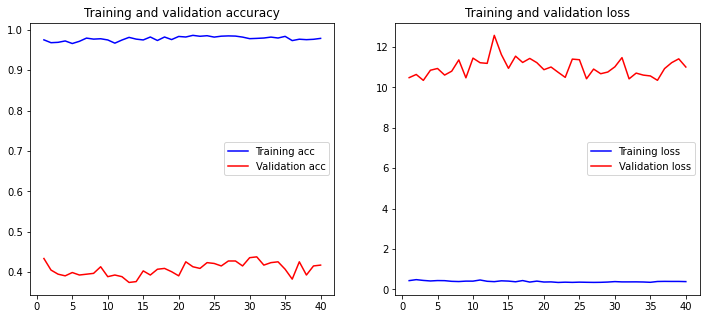

In [ ]:
plot_history(history2)